In [29]:
import matplotlib.pyplot as plt

plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsfonts}'

allowed_color = 'Green'
polylog_color = 'Black'
noyhat_color = 'Orange'
giantstep_color = 'Blue'
notallowed_color = 'Red'
processnotdefined_color = 'Purple'
sweetspot_color = 'cyan'

In [30]:
from giant_learning.poly_poly import ProjectedH3H3Overlaps
from giant_learning.gradient_descent import ProjectedGradientDescent, GradientDescent

import numpy as np
from sklearn.preprocessing import normalize
from scipy.linalg import orth

l=3
mus = [l/3] #, l/2, (l/2+l-1)/2]
gamma_prefactor = .01

p = 1
k = 1
d = 2**9
noise = 1e-6
t = 1./np.sqrt(d)  
seed = 23
ic_seed = 0
ic_seed ^= 981908

target = ProjectedH3H3Overlaps._target
activation = np.tanh
activation_derivative = ProjectedH3H3Overlaps._activation_derivative


sim_plainsgd_test_errors = []
sim_plainsgd_meancorrelation = []
sim_projsgd_test_errors = []
sim_projsgd_meancorrelation = []
sim_plaicorr_test_errors = []
sim_plaicorr_meancorrelation = []
sim_projcorr_test_errors = []
sim_projcorr_meancorrelation = []




## Initial condition
rng = np.random.default_rng(ic_seed)
init_corr = 1/np.sqrt(d)
Wtarget = orth((normalize(rng.normal(size=(k,d)), axis=1, norm='l2')).T).T
Wtild = normalize(rng.normal(size=(p,d)), axis=1, norm='l2')
Wtild_target = np.einsum('ji,ri,rh->jh', Wtild , Wtarget ,Wtarget)
W0_orth =  normalize(Wtild - Wtild_target, axis=1, norm='l2')
W0 = (init_corr*normalize(Wtild_target,norm='l2',axis=1) + np.sqrt(1-init_corr**2)*W0_orth)
a0 = rng.binomial(1, 0.5, p) * 2 - 1

P = Wtarget @ Wtarget.T
M0 = W0 @ Wtarget.T
Q0 = W0 @ W0.T

if (M0[0][0] < 0):
    W0 = -W0
    M0 = -M0

for mu in mus:
    n = int(np.power(d,mu))
    T = 2500000 // n
    gamma = gamma_prefactor * n * p * np.power(d,-3/2)
    gd_plain = GradientDescent(
        target, Wtarget, n,
        activation, W0, a0, activation_derivative,
        gamma, noise, predictor_interaction=True,
        test_size = None, analytical_error= 'H3H3',
        seed = seed
    )

    gd_proj = ProjectedGradientDescent(
        target, Wtarget, n,
        activation, W0, a0, activation_derivative,
        gamma, noise, predictor_interaction=True,
        test_size = None, analytical_error= 'H3H3',
        seed = seed
    )

    corr_plain = GradientDescent(
        target, Wtarget, n,
        activation, W0, a0, activation_derivative,
        gamma, noise, predictor_interaction=False,
        test_size = None, analytical_error= 'H3H3',
        seed = seed
    )

    corr_proj = ProjectedGradientDescent(
        target, Wtarget, n,
        activation, W0, a0, activation_derivative,
        gamma, noise, predictor_interaction=False,
        test_size = None, analytical_error= 'H3H3',
        seed = seed
    )

    gd_plain.train(T, verbose = True)
    gd_proj.train(T, verbose = True)
    corr_plain.train(T, verbose = True)
    corr_proj.train(T, verbose = True)

    sim_plainsgd_test_errors.append(np.array(gd_plain.test_errors))
    sim_projsgd_test_errors.append(np.array(gd_proj.test_errors))
    sim_plaicorr_test_errors.append(np.array(corr_plain.test_errors))
    sim_projcorr_test_errors.append(np.array(corr_proj.test_errors))

    def compute_mean_correlation(gd):
        Ws = np.array(gd.W_s)
        Wt = np.array(gd.W_target)
        Ms = np.einsum('tia,ja->tij', Ws, Wt)
        return np.max(Ms, axis=(1,2))
    sim_plainsgd_meancorrelation.append(compute_mean_correlation(gd_plain))
    sim_projsgd_meancorrelation.append(compute_mean_correlation(gd_proj))
    sim_plaicorr_meancorrelation.append(compute_mean_correlation(corr_plain))
    sim_projcorr_meancorrelation.append(compute_mean_correlation(corr_proj))

100%|██████████| 4882/4882 [04:36<00:00, 17.63it/s]


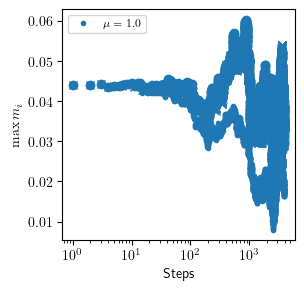

In [31]:
fig, ax = plt.subplots(1,1,figsize=(3,3))

for i,mu in enumerate(mus):
    T = len(sim_plainsgd_meancorrelation[i])
    # Test error
    R0 = 1.0
    # ax.plot(sim_correlationsgd_test_errors/R0, label=f'Correlation Loss SGD', marker='', ls='-', color='blue')
    # ax.plot(sim_plainsgd_test_errors/R0, label=f'SGD', marker='', ls='-', color='red')
    # Correlation M
    plain_plot = ax.plot(sim_plainsgd_meancorrelation[i][:int(.8*T)], label=f'$\\mu={mu}$', marker='.', ls='')
    proj_plot = ax.plot(sim_projsgd_meancorrelation[i][:int(.8*T)], marker='x', ls='', color=plain_plot[0].get_color())

    corr_plain_plot = ax.plot(sim_plaicorr_meancorrelation[i][:int(.8*T)], marker='o', ls='', color=plain_plot[0].get_color())
    corr_proj_plot = ax.plot(sim_projcorr_meancorrelation[i][:int(.8*T)], marker='*', ls='', color=plain_plot[0].get_color())


ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel('Steps')
ax.set_ylabel(r'$\max{m_i}$')
# ax.set_xlim([0,T])
# ax.set_ylim([2,5])
ax.legend(fontsize=8, loc='upper left')

plt.savefig(f'figures/multiindex_mu.pdf', bbox_inches = 'tight')

